# NAS Parallel Benchmarks

This notebook shows results of running NAS parallel benchmarks with gem5art. Only two cpu models are used in these runs. KVM cpu is used with class A, B, C and D of NPB, while atomic cpu is used with only class A of NPB. For details on how to run these experiments with gem5art, refer to the documentation [here](https://gem5art.readthedocs.io/en/latest/npb-tutorial.html).

In [91]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [92]:
datadir = '/run/user/1000/gvfs/sftp:host=amarillo.cs.ucdavis.edu/fasthome/aakahlow/npb_tests/results/run_npb/'

In [93]:
Benchmarks = sorted(os.listdir(datadir))
print(Benchmarks)

['bt.x', 'cg.x', 'ep.x', 'ft.x', 'is.x', 'lu.x', 'mg.x', 'sp.x']


In [94]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    try: 
        with open(filename) as f:
            r = f.read()
            if len(r) < 10: return 0.0
            start = r.find(stat) + len(stat) + 1
            end = r.find('#', start)
            return float(r[start:end])
    except: #temporary change
        return 0.0

In [95]:
def getStatus(filename):
    out_file = os.path.join(datadir, '', filename, 'simout').replace('\\','/')
    err_file = os.path.join(datadir, '', filename, 'simerr').replace('\\','/')
    status = ''
    try: 
        with open(out_file) as f:
            l_line = f.readlines()[-1]
            if 'Total wallclock time:' in l_line:
                status = 'success'
            else:
                status = 'N/A'
    except: #temporary change
        status = 'N/A'

    try: 
        with open(err_file) as f:
            l_line = f.readlines()[-1]
            if '--- END LIBC BACKTRACE ---' in l_line:
                status = 'failure'
    except:
        status = 'N/A'    
    
    return status

In [96]:
Cpus = ['kvm','atomic']
Cores = ['1', '4']
Classes = ['A','B','C','D']

In [97]:
rows = []

for bm in Benchmarks:
    for clas in Classes:
        for cpu in Cpus:
            for core in Cores:                
                #if cpu == 'atomic' and clas != 'A':
                #    continue
                file_path = '{}/{}/{}/{}/{}/'.format(datadir,bm,clas,cpu,core)
                
                rows.append([bm,clas,cpu,core,
                     getStatus(file_path),
                     gem5GetStat(file_path, 'sim_ticks')/333, #1000
                     gem5GetStat(file_path, 'sim_insts')/1000000,
                     gem5GetStat(file_path, 'sim_ops'),
                     gem5GetStat(file_path, 'sim_seconds'),
                     gem5GetStat(file_path, 'host_seconds')/60])             


df = pd.DataFrame(rows, columns=['benchmark','class','cpu','core','status','cycles', 'instructions', 'ops', 'sim_time', 'host_time'])

df['host_hours'] = df['host_time']/60
df['ipc'] = df['instructions']/df['cycles']
df['cpi'] = df['cycles']/df['instructions']
df['opc'] = df['ops']/df['cycles']
                     
#print(df)

In [99]:
def doplot_status(cpu):
    if cpu == 'atomic':
        Classes_2_use = ['A']
    else:
        Classes_2_use = Classes
    plt.figure()
    i = 0
    barWidth = 1
    for bm in Benchmarks:
        for core in Cores:
            for j,clas in enumerate(Classes):
                d = df[(df['core']==core) & (df['cpu']==cpu) & (df['benchmark']==bm) & (df['class']==clas)]
                if d['status'].iloc[0] == 'success':
                    plt.bar(i, 1, bottom=j, color='C'+ str(2),edgecolor='white',width=barWidth)
                if d['status'].iloc[0] == 'N/A':
                    plt.bar(i, 1, bottom=j, color='C'+ str(1),edgecolor='white',width=barWidth)
                if d['status'].iloc[0] == 'failure':
                    plt.bar(i, 1, bottom=j, color='C'+ str(3),edgecolor='white',width=barWidth)                                        
            i = i+1
        i = i+1
    
    colours = ['C'+ str(1), 'C'+ str(3), 'C'+ str(2)]#'R', 'Y']
    for i,cpu in enumerate(['N/A','failure', 'success']):
        plt.bar(0,0,color=colours[i], label=cpu)
    
    plt.xticks(list(set(np.arange(len(Benchmarks)*(len(Cores)+1)))-set([2,5,8,11,14,17,20,23])), Cores+Cores+Cores+Cores+Cores+Cores+Cores+Cores+Cores+Cores, rotation=0, ha='left')

## Benchmark Working Status
The next plots show the status of working of NPB on gem5. Each plot is drawn for a particular cpu (kvm and atomic). It should be noted that only class A of NPB is tested with atomic cpu so far, so rest of the classes will always show N/A.

<IPython.core.display.Javascript object>


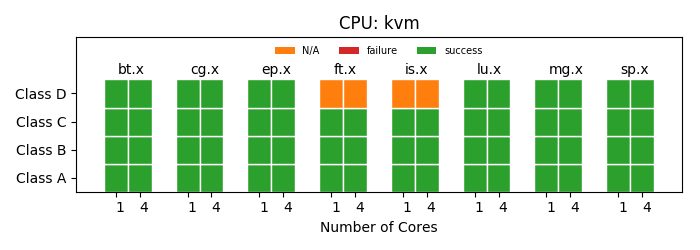

<IPython.core.display.Javascript object>


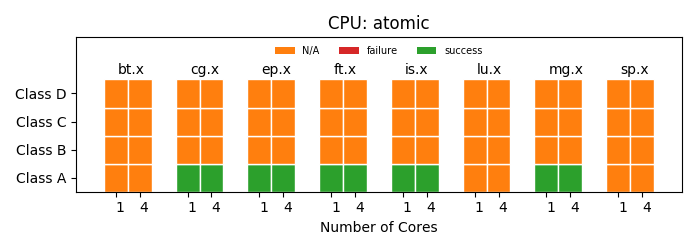

In [100]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_ty in ['kvm','atomic']:
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 7
    fig_size[1] = 2.5
    doplot_status(cpu_ty)
    plt.yticks([0.5,1.5,2.5,3.5], ('Class A', 'Class B', 'Class C', 'Class D'))
    #plt.ylabel('Sim Time (seconds)')
    plt.ylim(ymax = 5.5, ymin = 0)
    #plt.yscale( "log")
    
    for b, bm in enumerate(Benchmarks):
        plt.text(0.1+(b*3), 4.2, '{}'.format(bm, fontsize=9))
    plt.xlabel('Number of Cores')
    plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
    plt.title('CPU: {}'.format(cpu_ty))
    plt.tight_layout()

In [33]:
#print(df[df['benchmark']=='is.x'])

In [34]:
def doplot(cpu,core,stat,norm=False):
    plt.figure()
    i = 0
    if cpu == 'atomic':
        classes = ['A']
    else:
        classes = Classes
    
    for bm in Benchmarks:
        for j,clas in enumerate(classes):
            d = df[(df['benchmark']==bm) & (df['class']==clas) & (df['cpu']==cpu) & (df['core']==core)]
            plt.bar(i, d[stat].iloc[0], color='C'+str(j))
            i = i+1
        i = i+1
                    
    for i,clas in enumerate(classes):
        plt.bar(0,0,color='C'+str(i), label=clas)
        if cpu == 'atomic':
            #print('AC')
            plt.xticks(np.arange(len(Benchmarks))*2, Benchmarks, rotation=40, ha='right')        
        else:
            plt.xticks(np.arange(len(Benchmarks))*(len(Classes)+1)+1.5, Benchmarks, rotation=40, ha='right')
        

# Simulation Statistics

## Simulated Time (Seconds) 

<IPython.core.display.Javascript object>


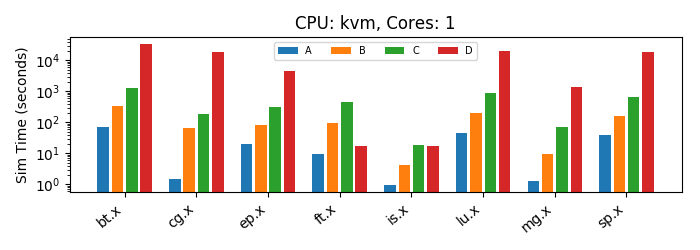

<IPython.core.display.Javascript object>


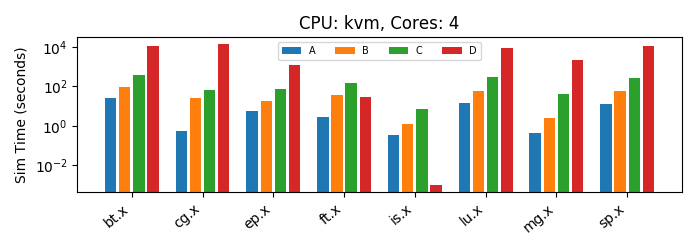

<IPython.core.display.Javascript object>


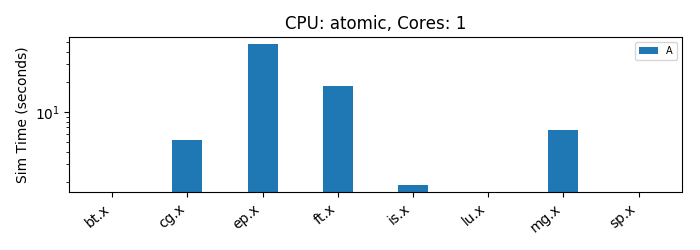

<IPython.core.display.Javascript object>


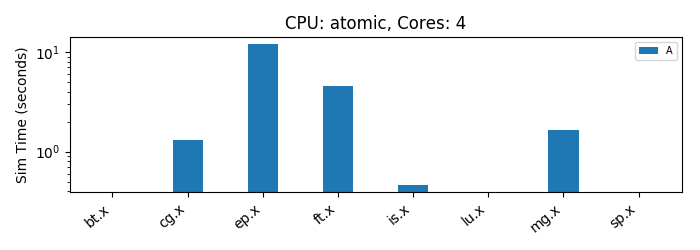

In [36]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_ty in ['kvm','atomic']:
    for core_cn in ['1','4']:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 7
        fig_size[1] = 2.5
        doplot(cpu_ty,core_cn,'sim_time')
        plt.ylabel('Sim Time (seconds)')
        #plt.ylim(ymax = 1000, ymin = 0)
        plt.yscale( "log")
        plt.legend(loc=0, ncol=4, prop={'size': 7})
        plt.title('CPU: {}, Cores: {}'.format(cpu_ty,core_cn))
        plt.tight_layout()


## Number of Instructions (in millions)

<IPython.core.display.Javascript object>


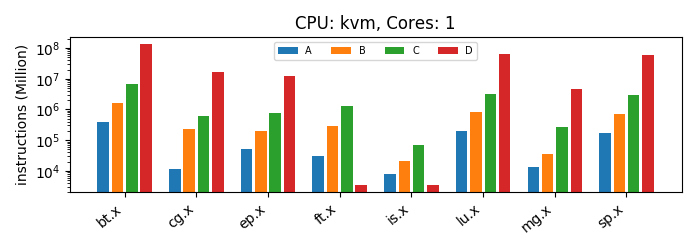

<IPython.core.display.Javascript object>


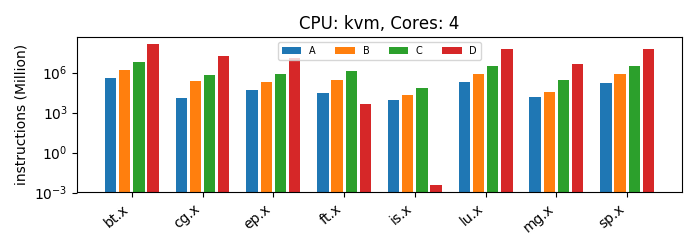

<IPython.core.display.Javascript object>


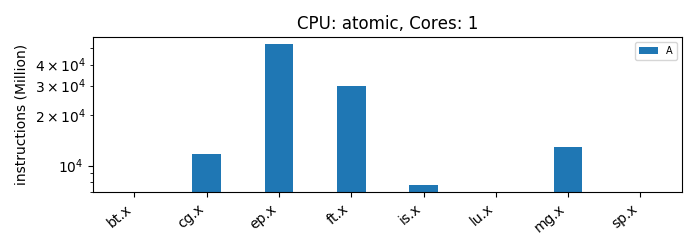

<IPython.core.display.Javascript object>


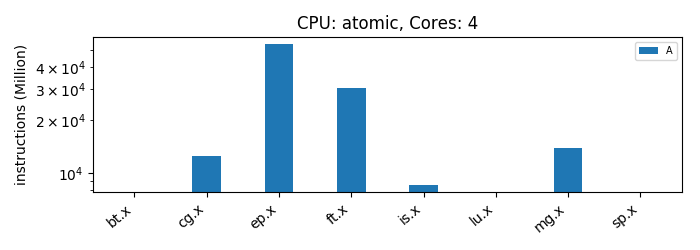

In [37]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_typ in ['kvm','atomic']:
    for core_cn in ['1','4']:#,'4']:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 7
        fig_size[1] = 2.5
        doplot(cpu_typ,core_cn,'instructions')
        plt.ylabel('instructions (Million)')
        plt.yscale( "log")
        #plt.ylim(ymax = 7000000, ymin = 0)
        plt.legend(loc=0, ncol=4, prop={'size': 7})
        plt.title('CPU: {}, Cores: {}'.format(cpu_typ,core_cn))
        plt.tight_layout()

## Host Time (minutes)

<IPython.core.display.Javascript object>


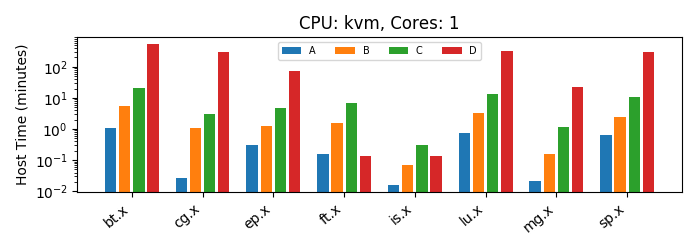

<IPython.core.display.Javascript object>


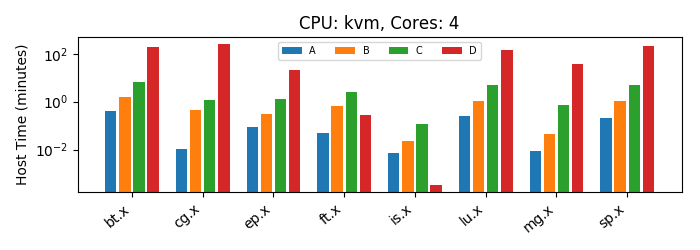

<IPython.core.display.Javascript object>


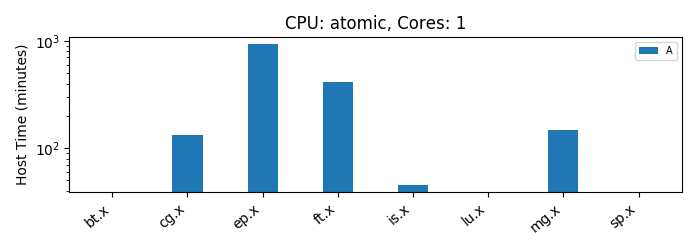

<IPython.core.display.Javascript object>


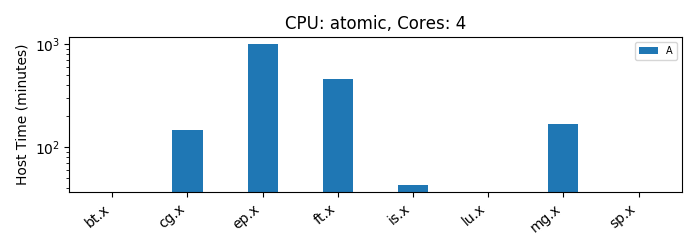

In [38]:
#plt.rcParams["figure.figsize"] = fig_size
for cpu_typ in ['kvm','atomic']:
    for core_cn in ['1','4']:#,'4']:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 7
        fig_size[1] = 2.5
        doplot(cpu_typ,core_cn,'host_time')
        plt.ylabel('Host Time (minutes)')
        plt.yscale("log")
        #plt.ylim(ymax = 100, ymin = 0)
        plt.legend(loc=0, ncol=4, prop={'size': 7})
        plt.title('CPU: {}, Cores: {}'.format(cpu_typ,core_cn))
        plt.tight_layout()